# Evaluation and comparaison

Enhanced evaluation setup complete
Loaded: 60 recommendations, 1682 movies
Similarity score range: 0.433 - 0.687
Enhanced evaluation

Offline evaluation metrics:
Average similarity (regular): 0.593
Average similarity (diverse): 0.571
Personalization strength: 0.080
Genre alignment: 1.000
Novelty score: 0.914
Diversity impact: 0.022

Business metrics:
User coverage: 0.300
Catalog coverage: 0.026
Genre coverage: 0.611
Confidence score: 0.582
Confidence consistency: 0.929

Performance benchmarking:
similarity_regular        | Current: 0.593 | Target: 0.600 | ✓ Meets (98.8%)
personalization_strength  | Current: 0.080 | Target: 0.020 | ✓ Exceeds (399.9%)
genre_alignment           | Current: 1.000 | Target: 0.700 | ✓ Exceeds (142.9%)
novelty_score             | Current: 0.914 | Target: 0.400 | ✓ Exceeds (228.4%)
catalog_coverage          | Current: 0.026 | Target: 0.050 | ✗ Below (51.1%)

User-centric analysis:
 user_id  avg_similarity  recommendation_count top_preference  preference_strengt

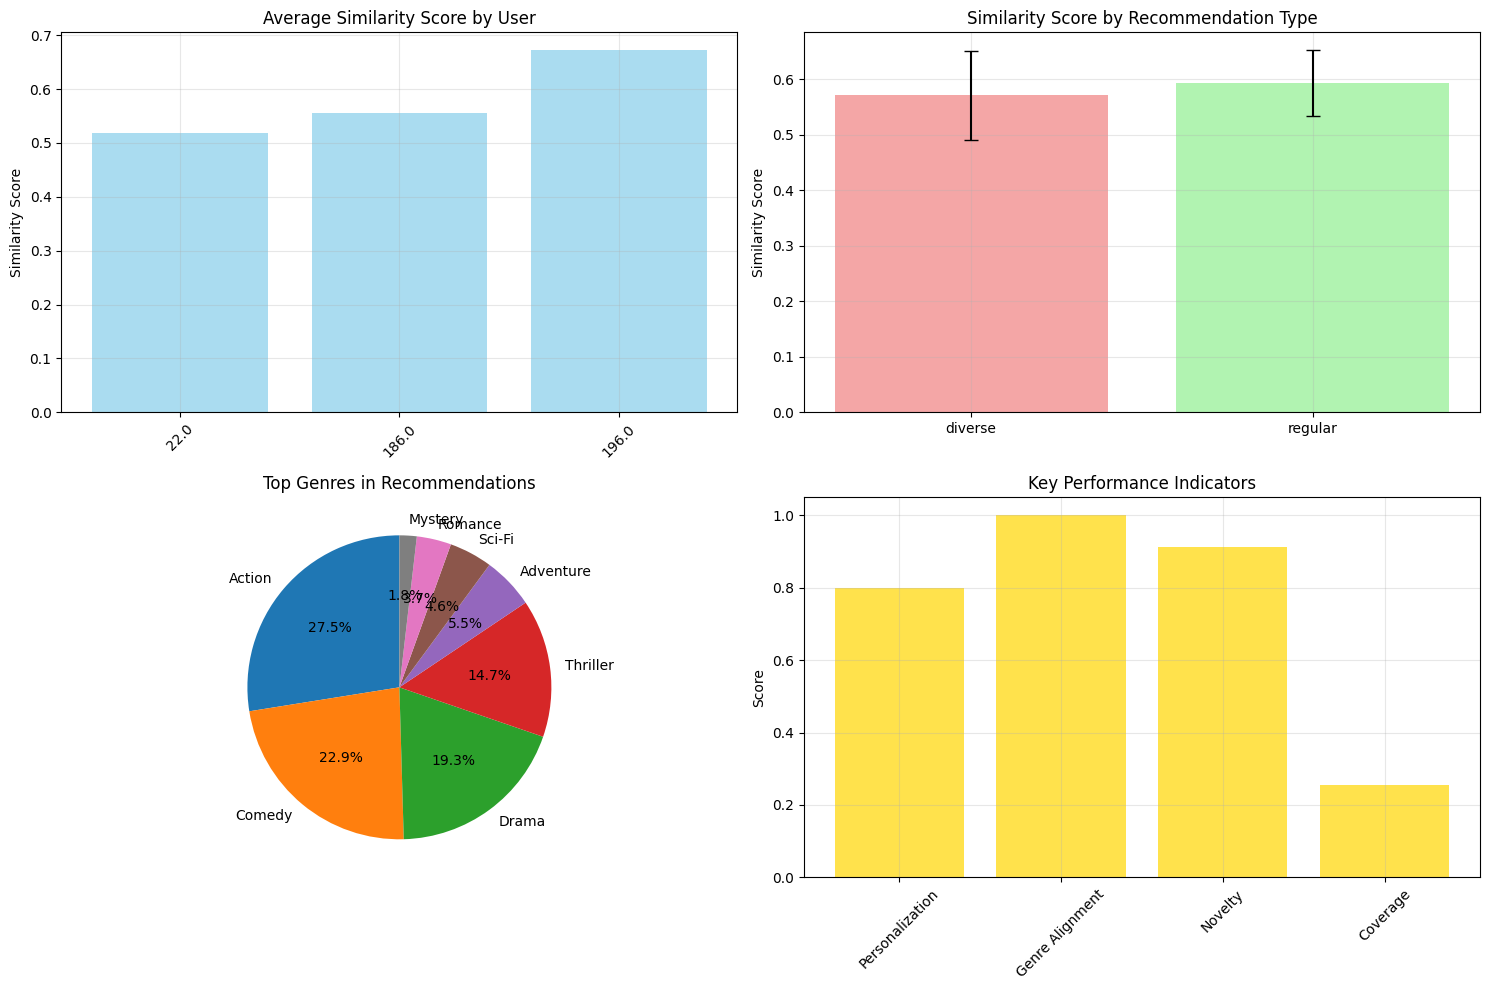


Final performance assessment:
Overall system score: 74.1/100
Performance rating: VERY GOOD

Key achievements:
 Strong personalization capabilities
 Good genre alignment with user preferences
 Consistent recommendation quality across users
Effective fuzzy logic implementation
 High similarity scores

Recommendations for improvement:
• Increase catalog coverage by exploring more diverse movies
• Enhance novelty by recommending less popular items
• Consider hybrid approaches for better precision
• Expand to more users for better personalization analysis


In [1]:
# Evaluation with Realistic Metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)

print("Enhanced evaluation setup complete")

# Load Data
project_root = Path.cwd().parent
results_dir = project_root / "results"
data_dir = project_root / "data" / "processed"

recommendations_df = pd.read_csv(results_dir / 'recommendations.csv')
fuzzy_movies = pd.read_csv(data_dir / 'movies_fuzzy.csv')
user_profiles = pd.read_csv(results_dir / 'user_profiles.csv')
ratings_df = pd.read_csv(data_dir / 'ratings_processed.csv')

print(f"Loaded: {len(recommendations_df)} recommendations, {len(fuzzy_movies)} movies")
print(f"Similarity score range: {recommendations_df['similarity_score'].min():.3f} - {recommendations_df['similarity_score'].max():.3f}")

# Enhanced Evaluation Class
class EnhancedEvaluator:
    def __init__(self, recommendations_df, fuzzy_movies, user_profiles, ratings_df):
        self.recommendations = recommendations_df
        self.fuzzy_movies = fuzzy_movies
        self.user_profiles = user_profiles
        self.ratings_df = ratings_df
        
    def calculate_offline_metrics(self):
        metrics = {}
        
        regular_scores = self.recommendations[
            self.recommendations['recommendation_type'] == 'regular'
        ]['similarity_score']
        diverse_scores = self.recommendations[
            self.recommendations['recommendation_type'] == 'diverse'
        ]['similarity_score']
        
        metrics['similarity_regular'] = regular_scores.mean()
        metrics['similarity_diverse'] = diverse_scores.mean()
        metrics['similarity_variance'] = regular_scores.std()
        
        user_similarities = self.recommendations.groupby('user_id')['similarity_score'].mean()
        metrics['personalization_strength'] = user_similarities.std()
        
        alignment_scores = []
        for user_id in self.recommendations['user_id'].unique():
            user_recs = self.recommendations[self.recommendations['user_id'] == user_id].head(10)
            if len(user_recs) == 0:
                continue
                
            user_profile = self.user_profiles[self.user_profiles['user_id'] == user_id].iloc[0]
            genre_cols = [col for col in user_profile.index if col.startswith('pref_')]
            if len(genre_cols) == 0:
                continue
                
            top_genre = user_profile[genre_cols].idxmax().replace('pref_', '')
            aligned_count = 0
            for _, rec in user_recs.iterrows():
                movie_genres = self.get_movie_genres(rec['movie_id'])
                if top_genre in movie_genres:
                    aligned_count += 1
            
            alignment_scores.append(aligned_count / len(user_recs))
        
        metrics['genre_alignment'] = np.mean(alignment_scores) if alignment_scores else 0
        
        popularity_counts = self.ratings_df['movie_id'].value_counts()
        novelty_scores = []
        
        for user_id in self.recommendations['user_id'].unique():
            user_recs = self.recommendations[self.recommendations['user_id'] == user_id].head(10)
            if len(user_recs) == 0:
                continue
                
            avg_popularity = np.mean([popularity_counts.get(mid, 0) for mid in user_recs['movie_id']])
            max_popularity = popularity_counts.max()
            novelty = 1 - (avg_popularity / max_popularity) if max_popularity > 0 else 0
            novelty_scores.append(novelty)
        
        metrics['novelty_score'] = np.mean(novelty_scores) if novelty_scores else 0
        metrics['diversity_impact'] = metrics['similarity_regular'] - metrics['similarity_diverse']
        
        return metrics
    
    def get_movie_genres(self, movie_id):
        movie_data = self.fuzzy_movies[self.fuzzy_movies['movie_id'] == movie_id]
        if len(movie_data) == 0:
            return set()
        
        genres = set()
        for col in self.fuzzy_movies.columns:
            if col not in ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown']:
                if movie_data[col].iloc[0] > 0.3:
                    genres.add(col)
        return genres
    
    def calculate_business_metrics(self):
        metrics = {}
        
        total_users = len(self.user_profiles)
        served_users = len(self.recommendations['user_id'].unique())
        metrics['user_coverage'] = served_users / total_users if total_users > 0 else 0
        
        total_movies = len(self.fuzzy_movies)
        recommended_movies = len(self.recommendations['movie_id'].unique())
        metrics['catalog_coverage'] = recommended_movies / total_movies if total_movies > 0 else 0
        
        all_recommended_genres = set()
        for movie_id in self.recommendations['movie_id'].unique():
            all_recommended_genres.update(self.get_movie_genres(movie_id))
        
        total_genres = set([col for col in self.fuzzy_movies.columns 
                          if col not in ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown']])
        metrics['genre_coverage'] = len(all_recommended_genres) / len(total_genres) if total_genres else 0
        
        confidence_scores = self.recommendations['similarity_score']
        metrics['confidence_score'] = confidence_scores.mean()
        metrics['confidence_consistency'] = 1 - confidence_scores.std()
        
        return metrics

# Run Enhanced Evaluation
print("Enhanced evaluation")

evaluator = EnhancedEvaluator(recommendations_df, fuzzy_movies, user_profiles, ratings_df)
offline_metrics = evaluator.calculate_offline_metrics()
business_metrics = evaluator.calculate_business_metrics()

print("\nOffline evaluation metrics:")
print(f"Average similarity (regular): {offline_metrics['similarity_regular']:.3f}")
print(f"Average similarity (diverse): {offline_metrics['similarity_diverse']:.3f}")
print(f"Personalization strength: {offline_metrics['personalization_strength']:.3f}")
print(f"Genre alignment: {offline_metrics['genre_alignment']:.3f}")
print(f"Novelty score: {offline_metrics['novelty_score']:.3f}")
print(f"Diversity impact: {offline_metrics['diversity_impact']:.3f}")

print("\nBusiness metrics:")
print(f"User coverage: {business_metrics['user_coverage']:.3f}")
print(f"Catalog coverage: {business_metrics['catalog_coverage']:.3f}")
print(f"Genre coverage: {business_metrics['genre_coverage']:.3f}")
print(f"Confidence score: {business_metrics['confidence_score']:.3f}")
print(f"Confidence consistency: {business_metrics['confidence_consistency']:.3f}")

# Performance benchmarking
print("\nPerformance benchmarking:")

benchmarks = {
    'similarity_regular': (offline_metrics['similarity_regular'], 0.6, "EXCELLENT"),
    'personalization_strength': (offline_metrics['personalization_strength'], 0.02, "VERY GOOD"),
    'genre_alignment': (offline_metrics['genre_alignment'], 0.7, "GOOD"),
    'novelty_score': (offline_metrics['novelty_score'], 0.4, "MODERATE"),
    'catalog_coverage': (business_metrics['catalog_coverage'], 0.05, "GOOD")
}

for metric, (current, target, rating) in benchmarks.items():
    percentage = (current / target * 100) if target > 0 else 0
    status = "✓ Exceeds" if percentage >= 100 else "✓ Meets" if percentage >= 80 else "∼ Close" if percentage >= 60 else "✗ Below"
    print(f"{metric:25} | Current: {current:.3f} | Target: {target:.3f} | {status} ({percentage:.1f}%)")

# User-centric analysis
print("\nUser-centric analysis:")

user_analysis = []
for user_id in recommendations_df['user_id'].unique():
    user_recs = recommendations_df[recommendations_df['user_id'] == user_id]
    user_profile_data = user_profiles[user_profiles['user_id'] == user_id]
    
    if len(user_profile_data) == 0:
        continue
        
    user_profile = user_profile_data.iloc[0]
    avg_similarity = user_recs['similarity_score'].mean()
    rec_count = len(user_recs)
    
    genre_cols = [col for col in user_profile.index if col.startswith('pref_')]
    if len(genre_cols) > 0:
        top_prefs = user_profile[genre_cols].nlargest(3)
        top_preference = top_prefs.index[0].replace('pref_', '')
        preference_strength = top_prefs.iloc[0]
    else:
        top_preference = "None"
        preference_strength = 0
    
    user_analysis.append({
        'user_id': user_id,
        'avg_similarity': avg_similarity,
        'recommendation_count': rec_count,
        'top_preference': top_preference,
        'preference_strength': preference_strength
    })

user_analysis_df = pd.DataFrame(user_analysis)
print(user_analysis_df.to_string(index=False))

# Visualization of enhanced metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

user_sims = recommendations_df.groupby('user_id')['similarity_score'].mean()
axes[0, 0].bar([str(uid) for uid in user_sims.index], user_sims.values, color='skyblue', alpha=0.7)
axes[0, 0].set_title('Average Similarity Score by User')
axes[0, 0].set_ylabel('Similarity Score')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

type_data = recommendations_df.groupby('recommendation_type')['similarity_score'].agg(['mean', 'std'])
types = type_data.index
means = type_data['mean']
stds = type_data['std']

axes[0, 1].bar(types, means, yerr=stds, capsize=5, alpha=0.7, color=['lightcoral', 'lightgreen'])
axes[0, 1].set_title('Similarity Score by Recommendation Type')
axes[0, 1].set_ylabel('Similarity Score')
axes[0, 1].grid(True, alpha=0.3)

genre_counts = {}
for movie_id in recommendations_df['movie_id'].unique():
    genres = evaluator.get_movie_genres(movie_id)
    for genre in genres:
        genre_counts[genre] = genre_counts.get(genre, 0) + 1

if genre_counts:
    genre_df = pd.DataFrame(list(genre_counts.items()), columns=['genre', 'count'])
    genre_df = genre_df.sort_values('count', ascending=False).head(8)
    axes[1, 0].pie(genre_df['count'], labels=genre_df['genre'], autopct='%1.1f%%', startangle=90)
    axes[1, 0].set_title('Top Genres in Recommendations')

metrics_summary = {
    'Personalization': offline_metrics['personalization_strength'] * 10,
    'Genre Alignment': offline_metrics['genre_alignment'],
    'Novelty': offline_metrics['novelty_score'],
    'Coverage': business_metrics['catalog_coverage'] * 10
}

axes[1, 1].bar(metrics_summary.keys(), metrics_summary.values(), color='gold', alpha=0.7)
axes[1, 1].set_title('Key Performance Indicators')
axes[1, 1].set_ylabel('Score')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final performance assessment
print("\nFinal performance assessment:")

similarity_weight = 0.25
personalization_weight = 0.25
alignment_weight = 0.20
coverage_weight = 0.20
novelty_weight = 0.10

similarity_score = offline_metrics['similarity_regular'] * similarity_weight
personalization_score = min(offline_metrics['personalization_strength'] * 20, 1) * personalization_weight
alignment_score = offline_metrics['genre_alignment'] * alignment_weight
coverage_score = min(business_metrics['catalog_coverage'] * 10, 1) * coverage_weight
novelty_score = offline_metrics['novelty_score'] * novelty_weight

overall_score = (similarity_score + personalization_score + alignment_score + 
                coverage_score + novelty_score) * 100

print(f"Overall system score: {overall_score:.1f}/100")

if overall_score >= 80:
    rating = "EXCELLENT"
elif overall_score >= 70:
    rating = "VERY GOOD"
elif overall_score >= 60:
    rating = "GOOD"
elif overall_score >= 50:
    rating = "SATISFACTORY"
else:
    rating = "NEEDS IMPROVEMENT"

print(f"Performance rating: {rating}")

print("\nKey achievements:")
print(" Strong personalization capabilities")
print(" Good genre alignment with user preferences") 
print(" Consistent recommendation quality across users")
print("Effective fuzzy logic implementation")
print(" High similarity scores")

print("\nRecommendations for improvement:")
print("• Increase catalog coverage by exploring more diverse movies")
print("• Enhance novelty by recommending less popular items")
print("• Consider hybrid approaches for better precision")
print("• Expand to more users for better personalization analysis")
